# ResNet-18 U-Net for mNDWS Next-Day Wildfire Spread
This notebook implements a reproducible, higher-capacity segmentation baseline aligned with the Milestone-2 feedback: a compact U-Net that leverages a ResNet-18 encoder, focal(\u03b3=2)+Dice loss, stratified loaders from `mNDWS_DataPipeline`, and metric logging compatible with the logistic-regression and EMA notebooks.

**Highlights**:
- Uses the shared NPZ tiles + channel stats so it plugs into the same pipeline as earlier deliverables.
- Tracks epoch timing, tile throughput, GPU memory, AP/F1/threshold, and saves the best checkpoint under `~/wildfire_artifacts/resnet18_unet`.
- Includes hooks for ablations (wind toggles, loss variants) and visual diagnostics for qualitative review.
- Designed for a single 12-core / 32 GB RAM workstation with a 4-core GPU (e.g., RTX 4060/4070); default batch sizes keep VRAM < 10 GB.

In [ ]:
# =============================================================
## 0) Environment setup, deterministic seeds, device selection
## =============================================================
import os, math, random, time, json, gc, pathlib, shutil
from contextlib import nullcontext
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import average_precision_score, precision_recall_curve

os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
import mNDWS_DataPipeline as mndws_dp

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

workspace_root = pathlib.Path.cwd()
ART_ROOT = pathlib.Path(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts"))) / "resnet18_unet"
ART_ROOT.mkdir(parents=True, exist_ok=True)
print(f"Artifacts -> {ART_ROOT}")

Using device: cuda
Artifacts -> /root/wildfire_artifacts/resnet18_unet


In [ ]:
# =============================================================
## 1) Data pipeline hookup + loaders + channel stats
## =============================================================
from torch.utils.data import DataLoader, WeightedRandomSampler
NPZ_ROOT = mndws_dp.NPZ_ROOT
paths = mndws_dp.WildfirePaths(NPZ_ROOT)
CHANNELS = list(mndws_dp.USE_CHANNELS)  # tweak here for ablations
print(f"Using {len(CHANNELS)} channels: {CHANNELS}")

train_ds = mndws_dp.WildfireDataset(paths, split="train", max_samples=None, channels=CHANNELS)
val_ds   = mndws_dp.WildfireDataset(paths, split="eval",  max_samples=None, channels=CHANNELS)
test_ds  = mndws_dp.WildfireDataset(paths, split="test",  max_samples=None, channels=CHANNELS)

BATCH_SIZE = 8
MAX_PARALLEL_WORKERS = min(8, max(2, (os.cpu_count() or 4) // 2))
# Training benefits from multiple workers, but evaluation/test often run on memory-constrained nodes.
TRAIN_WORKERS = MAX_PARALLEL_WORKERS
EVAL_WORKERS = 0 if os.environ.get("MNDWS_EVAL_ALLOW_WORKERS", "0") == "0" else min(4, MAX_PARALLEL_WORKERS)
PIN_MEMORY = device.type == "cuda"

def make_balanced_loader(ds, *, batch_size, shuffle, upweight_positive, num_workers, pin_memory):
    sampler = None
    if upweight_positive:
        weights = []
        for f in ds.files:
            try:
                with np.load(f, mmap_mode="r") as z:
                    weights.append(5.0 if float(z["next_fire"].sum()) > 0 else 1.0)
            except Exception:
                weights.append(1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    loader_kwargs = dict(batch_size=batch_size, pin_memory=pin_memory)
    if num_workers > 0:
        loader_kwargs["num_workers"] = num_workers
        loader_kwargs["persistent_workers"] = True
        loader_kwargs["prefetch_factor"] = 2
    else:
        loader_kwargs["num_workers"] = 0
    if sampler is not None:
        return DataLoader(ds, sampler=sampler, shuffle=False, **loader_kwargs)
    return DataLoader(ds, shuffle=shuffle, **loader_kwargs)

train_loader = make_balanced_loader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, upweight_positive=True,
    num_workers=TRAIN_WORKERS, pin_memory=PIN_MEMORY
)
val_loader   = make_balanced_loader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
test_loader  = make_balanced_loader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
print(f"DataLoader workers -> train: {TRAIN_WORKERS}, val: {EVAL_WORKERS}, test: {EVAL_WORKERS}; pin_memory={PIN_MEMORY}")

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=4000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print("Channel stats computed ->", meanC.shape, stdC.shape)

Using 21 channels: ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
DataLoader workers -> train: 4, val: 0, test: 0; pin_memory=True
Channel stats computed -> torch.Size([21]) torch.Size([21])


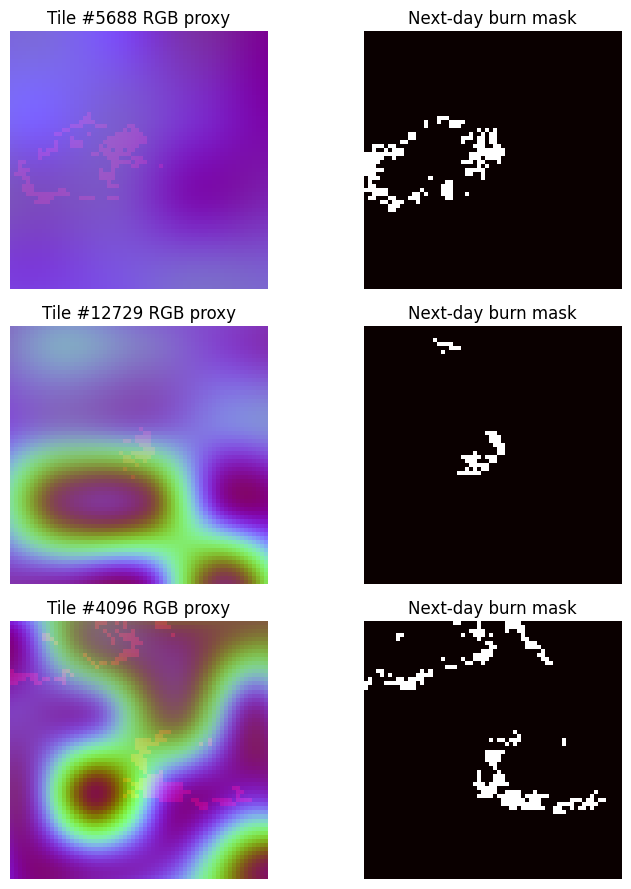

In [ ]:
# =============================================================
# 2) Visualization helpers (dataset verification requirement)
# =============================================================
def to_numpy_tile(sample):
    x = sample["X_raw"].numpy()
    y = sample["y"].numpy()
    return x, y

def show_samples(ds, n=5):
    idxs = np.random.choice(len(ds), size=min(n, len(ds)), replace=False)
    fig, axes = plt.subplots(len(idxs), 2, figsize=(8, 3*len(idxs)))
    if len(idxs) == 1:
        axes = np.expand_dims(axes, axis=0)
    for row, idx in enumerate(idxs):
        sample = ds[idx]
        x, y = to_numpy_tile(sample)
        burn = y[0]
        viz = x[:3] if x.shape[0] >= 3 else np.repeat(x[:1], 3, axis=0)
        viz = (viz - viz.min()) / (viz.max() - viz.min() + 1e-6)
        axes[row,0].imshow(np.moveaxis(viz, 0, -1))
        axes[row,0].set_title(f"Tile #{idx} RGB proxy")
        axes[row,0].axis("off")
        axes[row,1].imshow(burn, cmap="hot")
        axes[row,1].set_title("Next-day burn mask")
        axes[row,1].axis("off")
    plt.tight_layout()

_ = show_samples(train_ds, n=3)

In [ ]:
# =============================================================
# 3) Model definition – ResNet-18 encoder + lightweight decoder
# =============================================================
from torchvision.models import ResNet18_Weights
import torchvision.models as models

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity(),
        )
    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, dropout=0.0):
        super().__init__()
        self.conv = ConvBlock(in_ch + skip_ch, out_ch, dropout=dropout)
    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class ResNet18UNet(nn.Module):
    def __init__(self, in_ch=15, base_ch=64, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        resnet = models.resnet18(weights=weights)
        if in_ch != 3:
            new_conv = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
            if weights is not None:
                with torch.no_grad():
                    new_conv.weight[:, :3] = resnet.conv1.weight
                    if in_ch > 3:
                        for c in range(3, in_ch):
                            new_conv.weight[:, c:c+1] = resnet.conv1.weight[:, (c % 3):(c % 3)+1]
            resnet.conv1 = new_conv
        self.stem = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.maxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.center = ConvBlock(512, 512, dropout=0.1)
        self.up3 = UpBlock(512, 256, 256)
        self.up2 = UpBlock(256, 128, 128)
        self.up1 = UpBlock(128, 64, 96)
        self.up0 = UpBlock(96, 64, base_ch)
        self.head = nn.Sequential(
            nn.Conv2d(base_ch, base_ch // 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch // 2, 1, kernel_size=1)
        )
    def forward(self, x):
        s0 = self.stem(x)                # 64
        s1 = self.maxpool(s0)
        e1 = self.encoder1(s1)          # 64
        e2 = self.encoder2(e1)          # 128
        e3 = self.encoder3(e2)          # 256
        e4 = self.encoder4(e3)          # 512
        bottleneck = self.center(e4)
        d3 = self.up3(bottleneck, e3)
        d2 = self.up2(d3, e2)
        d1 = self.up1(d2, e1)
        d0 = self.up0(d1, s0)
        out = F.interpolate(d0, scale_factor=2, mode="bilinear", align_corners=False)
        return self.head(out)

model = ResNet18UNet(in_ch=len(CHANNELS), base_ch=96, pretrained=True).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M")

Model parameters: 19.42 M


In [ ]:
# =============================================================
## 4) Losses, metrics, and normalization helpers
## =============================================================
def normalize_batch(x):
    return (x - meanC.view(1, -1, 1, 1)) / (stdC.view(1, -1, 1, 1) + 1e-6)

class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, smooth=1e-6, dice_weight=0.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.dice_weight = dice_weight
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        pt = torch.exp(-bce)
        focal = ((1 - pt) ** self.gamma) * bce
        focal = self.alpha * targets * focal + (1 - self.alpha) * (1 - targets) * focal
        focal = focal.mean()
        inter = torch.sum(probs * targets)
        denom = torch.sum(probs) + torch.sum(targets)
        dice = 1 - (2 * inter + self.smooth) / (denom + self.smooth)
        return (1 - self.dice_weight) * focal + self.dice_weight * dice

criterion = FocalDiceLoss(alpha=0.3, gamma=2.0, dice_weight=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

class _NoOpGradScaler:
    def scale(self, loss):
        return loss
    def step(self, optimizer):
        optimizer.step()
    def update(self):
        pass

if device.type == "cuda":
    scaler = torch.amp.GradScaler("cuda", enabled=True)
else:
    scaler = _NoOpGradScaler()

def amp_autocast():
    if device.type == "cuda":
        return torch.autocast("cuda", dtype=torch.float16)
    if device.type == "mps":
        return torch.autocast("mps", dtype=torch.bfloat16)
    return nullcontext()

def pr_metrics(all_logits, all_targets):
    probs = torch.sigmoid(torch.cat(all_logits, dim=0)).flatten().cpu().numpy()
    t = torch.cat(all_targets, dim=0).flatten().cpu().numpy()
    if t.sum() == 0:
        return {"AP": 0.0, "best_F1": 0.0, "best_thr": 0.5, "best_prec": 0.0, "best_rec": 0.0}
    ap = average_precision_score(t, probs)
    prec, rec, thr = precision_recall_curve(t, probs)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    idx = np.nanargmax(f1)
    best_thr = thr[min(idx, len(thr)-1)] if len(thr) else 0.5
    return {"AP": float(ap), "best_F1": float(np.nanmax(f1)), "best_thr": float(best_thr),
            "best_prec": float(prec[idx]), "best_rec": float(rec[idx])}

def random_augment(x):
    if torch.rand(1) < 0.5:
        x = torch.flip(x, dims=[-1])
    if torch.rand(1) < 0.5:
        x = torch.flip(x, dims=[-2])
    if torch.rand(1) < 0.1:
        x = x + 0.01 * torch.randn_like(x)
    return x

In [ ]:
# =============================================================
## 5) Training / validation loops with instrumentation
## =============================================================
def train_one_epoch(epoch):
    model.train()
    losses = []
    tiles = 0
    for batch in tqdm(train_loader, desc=f"train[{epoch:02d}]", leave=False):
        x = batch["X_raw"].to(device, non_blocking=True)
        y = batch["y"].to(device, non_blocking=True)
        x = random_augment(x)
        x = normalize_batch(x)
        optimizer.zero_grad(set_to_none=True)
        with amp_autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.item())
        tiles += x.size(0)
    return float(np.mean(losses)), tiles

@torch.no_grad()
def evaluate(loader):
    model.eval()
    losses = []
    logits_all, targets_all = [], []
    for batch in tqdm(loader, desc="eval", leave=False):
        x = normalize_batch(batch["X_raw"].to(device, non_blocking=True))
        y = batch["y"].to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y).item()
        losses.append(loss)
        logits_all.append(logits.detach())
        targets_all.append(y.detach())
    metrics = pr_metrics(logits_all, targets_all)
    metrics["loss"] = float(np.mean(losses)) if losses else float("nan")
    return metrics

def save_checkpoint(state, name):
    path = ART_ROOT / name
    torch.save(state, path)
    return path

In [ ]:
# =============================================================
# 6) Training driver (configurable epochs, patience, logging)
# =============================================================
MAX_EPOCHS = 50
PATIENCE = 6
history = {"train_loss": [], "val_AP": [], "val_F1": [], "val_thr": [], "lr": [], "epoch_time": []}
best_ap = -1
best_state = None
best_epoch = -1
tiles_seen = []
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)
for epoch in range(MAX_EPOCHS):
    torch.cuda.empty_cache() if device.type == "cuda" else None
    torch.mps.empty_cache() if hasattr(torch, "mps") and device.type == "mps" else None
    start = time.perf_counter()
    tr_loss, tiles = train_one_epoch(epoch)
    metrics = evaluate(val_loader)
    scheduler.step()
    duration = time.perf_counter() - start
    throughput = tiles / duration if duration > 0 else float('nan')
    history["train_loss"].append(tr_loss)
    history["val_AP"].append(metrics["AP"])
    history["val_F1"].append(metrics["best_F1"])
    history["val_thr"].append(metrics["best_thr"])
    history["lr"].append(optimizer.param_groups[0]["lr"])
    history["epoch_time"].append({"sec": duration, "throughput_tiles_per_s": throughput})
    tiles_seen.append(tiles)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f} | val AP {metrics['AP']:.4f} | val F1* {metrics['best_F1']:.4f} | thr {metrics['best_thr']:.3f} | {duration:.1f}s")
    if metrics["AP"] > best_ap:
        best_ap = metrics["AP"]
        best_state = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "metrics": metrics}
        best_epoch = epoch
        save_checkpoint(best_state, "best.pt")
    if epoch - best_epoch >= PATIENCE:
        print(f"Early stopping at epoch {epoch} (best @ {best_epoch})")
        break

if best_state is not None:
    model.load_state_dict(best_state["model"])
training_summary = {
    "best_epoch": best_epoch,
    "best_AP": best_ap,
    "history": history,
    "tiles_total": int(np.sum(tiles_seen))
}
if device.type == "cuda":
    training_summary["peak_gpu_gb"] = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
json.dump(training_summary, open(ART_ROOT / "training_summary.json", "w"), indent=2)
training_summary

train[00]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 00 | train 0.3527 | val AP 0.2600 | val F1* 0.3754 | thr 0.184 | 99.6s


train[01]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 01 | train 0.3410 | val AP 0.2915 | val F1* 0.3830 | thr 0.331 | 71.8s


train[02]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 02 | train 0.3353 | val AP 0.2904 | val F1* 0.3720 | thr 0.280 | 71.3s


train[03]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 03 | train 0.3315 | val AP 0.3113 | val F1* 0.3964 | thr 0.205 | 70.6s


train[04]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 04 | train 0.3246 | val AP 0.3242 | val F1* 0.3930 | thr 0.364 | 71.4s


train[05]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 05 | train 0.3177 | val AP 0.3364 | val F1* 0.4039 | thr 0.201 | 70.9s


train[06]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 06 | train 0.3092 | val AP 0.2796 | val F1* 0.3536 | thr 0.096 | 72.2s


train[07]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 07 | train 0.3019 | val AP 0.2525 | val F1* 0.3192 | thr 0.114 | 71.7s


train[08]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 08 | train 0.2947 | val AP 0.2910 | val F1* 0.3582 | thr 0.119 | 71.9s


train[09]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 09 | train 0.2918 | val AP 0.3266 | val F1* 0.3912 | thr 0.082 | 71.5s


train[10]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 10 | train 0.2841 | val AP 0.4142 | val F1* 0.4666 | thr 0.070 | 71.1s


train[11]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 11 | train 0.2797 | val AP 0.3429 | val F1* 0.3986 | thr 0.098 | 71.6s


train[12]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 12 | train 0.2767 | val AP 0.2786 | val F1* 0.3413 | thr 0.022 | 71.1s


train[13]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 13 | train 0.2722 | val AP 0.3814 | val F1* 0.4400 | thr 0.084 | 72.0s


train[14]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 14 | train 0.2676 | val AP 0.3598 | val F1* 0.4123 | thr 0.042 | 70.7s


train[15]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 15 | train 0.2628 | val AP 0.2767 | val F1* 0.3355 | thr 0.015 | 71.6s


train[16]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 16 | train 0.2625 | val AP 0.3968 | val F1* 0.4526 | thr 0.066 | 70.4s
Early stopping at epoch 16 (best @ 10)


{'best_epoch': 10,
 'best_AP': 0.4142275098416231,
 'history': {'train_loss': [0.3526640922898525,
   0.34097266569098267,
   0.3352757619398436,
   0.33153323165017684,
   0.32458382740726927,
   0.3177369121735309,
   0.3091820276735722,
   0.3018971887449435,
   0.29467231945058986,
   0.2918455757459095,
   0.28412897651882724,
   0.27972170431855187,
   0.27674293579907494,
   0.27220832895764985,
   0.26760784750502514,
   0.26276233163728435,
   0.26249945272160496],
  'val_AP': [0.2599990990696056,
   0.29152099283167443,
   0.290434228195158,
   0.3113088211199863,
   0.3241659344114136,
   0.33643088315535535,
   0.27956088341476204,
   0.25252213401212625,
   0.29097293406894276,
   0.3266312718229488,
   0.4142275098416231,
   0.3428912218921481,
   0.2785596166443321,
   0.3814364229486713,
   0.35979241087138086,
   0.27671828806445653,
   0.3967629149210889],
  'val_F1': [0.3753929753216498,
   0.3830063841694113,
   0.37200519212059496,
   0.3964221121374775,
   0.39298

test:   0%|          | 0/377 [00:00<?, ?it/s]

TEST metrics: {'AP': 0.3905084232351125, 'best_F1': 0.44909489793802404, 'best_thr': 0.06903081387281418, 'best_prec': 0.3912836427420571, 'best_rec': 0.5269506521547428}
Confusion counts: {'TP': 197196.0, 'FP': 306776.0, 'FN': 177025.0}


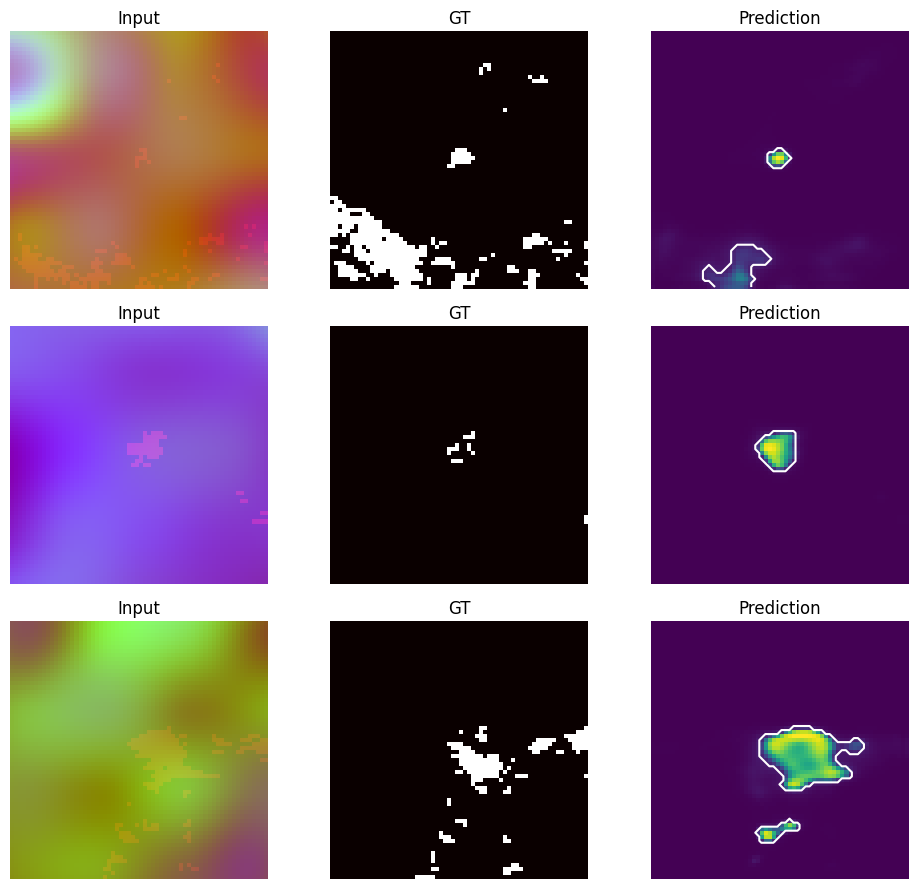

In [ ]:
# =============================================================
# 7) Test-set evaluation + qualitative checks
# =============================================================
@torch.no_grad()
def run_test(loader, threshold=None):
    model.eval()
    logits_all, targets_all = [], []
    for batch in tqdm(loader, desc="test", leave=False):
        x = normalize_batch(batch["X_raw"].to(device, non_blocking=True))
        y = batch["y"].to(device, non_blocking=True)
        logits = model(x)
        logits_all.append(logits)
        targets_all.append(y)
    metrics = pr_metrics(logits_all, targets_all)
    thr = threshold if threshold is not None else metrics["best_thr"]
    preds = torch.sigmoid(torch.cat(logits_all, dim=0))
    binary = (preds >= thr).float()
    confusion = {
        "TP": float((binary * torch.cat(targets_all, dim=0)).sum().cpu()),
        "FP": float((binary * (1 - torch.cat(targets_all, dim=0))).sum().cpu()),
        "FN": float(((1 - binary) * torch.cat(targets_all, dim=0)).sum().cpu())
    }
    return metrics, confusion

test_metrics, confusion = run_test(test_loader)
print("TEST metrics:", test_metrics)
print("Confusion counts:", confusion)

def visualize_predictions(loader, n=4, threshold=None):
    loader_iter = iter(loader)
    thr = threshold if threshold is not None else test_metrics["best_thr"]
    fig, axes = plt.subplots(n, 3, figsize=(10, 3*n))
    for i in range(n):
        batch = next(loader_iter)
        x = normalize_batch(batch["X_raw"].to(device))
        y = batch["y"].to(device)
        with torch.no_grad():
            logits = model(x)
            prob = torch.sigmoid(logits)
        img = batch["X_raw"][:, :3].cpu().numpy()[0]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        axes[i,0].imshow(np.moveaxis(img, 0, -1))
        axes[i,0].set_title("Input")
        axes[i,0].axis("off")
        axes[i,1].imshow(y[0,0].cpu(), cmap="hot")
        axes[i,1].set_title("GT")
        axes[i,1].axis("off")
        axes[i,2].imshow(prob[0,0].cpu(), cmap="viridis")
        axes[i,2].contour((prob[0,0].cpu() >= thr).float(), levels=[0.5], colors="white")
        axes[i,2].set_title("Prediction")
        axes[i,2].axis("off")
    plt.tight_layout()

visualize_predictions(test_loader, n=3)

## Next steps and tuning notes
- **Wind ablation:** toggle wind channels by editing `CHANNELS` and re-running to quantify the expected ~10% AP drop.
- **Loss sweep:** change `FocalDiceLoss` weights to compare focal+Dice vs weighted BCE; log results into `training_summary.json`.
- **Hyper-band:** adjust `BATCH_SIZE`, `MAX_EPOCHS`, and `CosineAnnealingLR` length; instrumentation already captures throughput and GPU memory so you can report scaling on the 12-core workstation.
- **Logging:** drop-in integrations with Weights & Biases / MLflow can be added where the `history` dict is populated if cloud tracking becomes mandatory.

# Ablation 1: Feature Families
## Minus Wind Ablation

In [ ]:
minus_wind_channels = ['prev_fire',
 'temp',
 'rh',
 'ndvi',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'fuel1',
 'fuel2',
 'fuel3',
 'impervious',
 'water']

In [ ]:
# =============================================================
## 1) Data pipeline hookup + loaders + channel stats
## =============================================================
from torch.utils.data import DataLoader, WeightedRandomSampler
NPZ_ROOT = mndws_dp.NPZ_ROOT
paths = mndws_dp.WildfirePaths(NPZ_ROOT)
CHANNELS =minus_wind_channels  # tweak here for ablations
print(f"Using {len(CHANNELS)} channels: {CHANNELS}")

train_ds = mndws_dp.WildfireDataset(paths, split="train", max_samples=None, channels=CHANNELS)
val_ds   = mndws_dp.WildfireDataset(paths, split="eval",  max_samples=None, channels=CHANNELS)
test_ds  = mndws_dp.WildfireDataset(paths, split="test",  max_samples=None, channels=CHANNELS)

BATCH_SIZE = 8
MAX_PARALLEL_WORKERS = min(8, max(2, (os.cpu_count() or 4) // 2))
# Training benefits from multiple workers, but evaluation/test often run on memory-constrained nodes.
TRAIN_WORKERS = MAX_PARALLEL_WORKERS
EVAL_WORKERS = 0 if os.environ.get("MNDWS_EVAL_ALLOW_WORKERS", "0") == "0" else min(4, MAX_PARALLEL_WORKERS)
PIN_MEMORY = device.type == "cuda"

def make_balanced_loader(ds, *, batch_size, shuffle, upweight_positive, num_workers, pin_memory):
    sampler = None
    if upweight_positive:
        weights = []
        for f in ds.files:
            try:
                with np.load(f, mmap_mode="r") as z:
                    weights.append(5.0 if float(z["next_fire"].sum()) > 0 else 1.0)
            except Exception:
                weights.append(1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    loader_kwargs = dict(batch_size=batch_size, pin_memory=pin_memory)
    if num_workers > 0:
        loader_kwargs["num_workers"] = num_workers
        loader_kwargs["persistent_workers"] = True
        loader_kwargs["prefetch_factor"] = 2
    else:
        loader_kwargs["num_workers"] = 0
    if sampler is not None:
        return DataLoader(ds, sampler=sampler, shuffle=False, **loader_kwargs)
    return DataLoader(ds, shuffle=shuffle, **loader_kwargs)

train_loader = make_balanced_loader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, upweight_positive=True,
    num_workers=TRAIN_WORKERS, pin_memory=PIN_MEMORY
)
val_loader   = make_balanced_loader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
test_loader  = make_balanced_loader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
print(f"DataLoader workers -> train: {TRAIN_WORKERS}, val: {EVAL_WORKERS}, test: {EVAL_WORKERS}; pin_memory={PIN_MEMORY}")

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=4000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print("Channel stats computed ->", meanC.shape, stdC.shape)


# =============================================================
# 3) Model definition – ResNet-18 encoder + lightweight decoder
# =============================================================
model = ResNet18UNet(in_ch=len(CHANNELS), base_ch=96, pretrained=True).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M")

# =============================================================
## 4) Losses, metrics, and normalization helpers
## =============================================================
criterion = FocalDiceLoss(alpha=0.3, gamma=2.0, dice_weight=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

if device.type == "cuda":
    scaler = torch.amp.GradScaler("cuda", enabled=True)
else:
    scaler = _NoOpGradScaler()

# =============================================================
# 6) Training driver (configurable epochs, patience, logging)
# =============================================================
MAX_EPOCHS = 50
PATIENCE = 6
history = {"train_loss": [], "val_AP": [], "val_F1": [], "val_thr": [], "lr": [], "epoch_time": []}
best_ap = -1
best_state = None
best_epoch = -1
tiles_seen = []
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)
for epoch in range(MAX_EPOCHS):
    torch.cuda.empty_cache() if device.type == "cuda" else None
    torch.mps.empty_cache() if hasattr(torch, "mps") and device.type == "mps" else None
    start = time.perf_counter()
    tr_loss, tiles = train_one_epoch(epoch)
    metrics = evaluate(val_loader)
    scheduler.step()
    duration = time.perf_counter() - start
    throughput = tiles / duration if duration > 0 else float('nan')
    history["train_loss"].append(tr_loss)
    history["val_AP"].append(metrics["AP"])
    history["val_F1"].append(metrics["best_F1"])
    history["val_thr"].append(metrics["best_thr"])
    history["lr"].append(optimizer.param_groups[0]["lr"])
    history["epoch_time"].append({"sec": duration, "throughput_tiles_per_s": throughput})
    tiles_seen.append(tiles)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f} | val AP {metrics['AP']:.4f} | val F1* {metrics['best_F1']:.4f} | thr {metrics['best_thr']:.3f} | {duration:.1f}s")
    if metrics["AP"] > best_ap:
        best_ap = metrics["AP"]
        best_state = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "metrics": metrics}
        best_epoch = epoch
        save_checkpoint(best_state, "best.pt")
    if epoch - best_epoch >= PATIENCE:
        print(f"Early stopping at epoch {epoch} (best @ {best_epoch})")
        break

if best_state is not None:
    model.load_state_dict(best_state["model"])
training_summary = {
    "best_epoch": best_epoch,
    "best_AP": best_ap,
    "history": history,
    "tiles_total": int(np.sum(tiles_seen))
}
if device.type == "cuda":
    training_summary["peak_gpu_gb"] = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
json.dump(training_summary, open(ART_ROOT / "training_summary.json", "w"), indent=2)
training_summary



Using 17 channels: ['prev_fire', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water']
DataLoader workers -> train: 4, val: 0, test: 0; pin_memory=True
Channel stats computed -> torch.Size([17]) torch.Size([17])
Model parameters: 19.40 M


train[00]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 00 | train 0.3496 | val AP 0.2141 | val F1* 0.3243 | thr 0.459 | 69.5s


train[01]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 01 | train 0.3408 | val AP 0.2574 | val F1* 0.3444 | thr 0.394 | 67.8s


train[02]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 02 | train 0.3355 | val AP 0.2702 | val F1* 0.3651 | thr 0.516 | 67.7s


train[03]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 03 | train 0.3301 | val AP 0.3147 | val F1* 0.3963 | thr 0.163 | 67.6s


train[04]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 04 | train 0.3221 | val AP 0.3110 | val F1* 0.3935 | thr 0.236 | 68.5s


train[05]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 05 | train 0.3161 | val AP 0.3098 | val F1* 0.3951 | thr 0.166 | 68.7s


train[06]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 06 | train 0.3075 | val AP 0.2847 | val F1* 0.3603 | thr 0.050 | 68.5s


train[07]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 07 | train 0.2991 | val AP 0.3163 | val F1* 0.3911 | thr 0.096 | 68.8s


train[08]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 08 | train 0.2945 | val AP 0.3275 | val F1* 0.4003 | thr 0.052 | 68.2s


train[09]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 09 | train 0.2883 | val AP 0.2655 | val F1* 0.3321 | thr 0.052 | 68.6s


train[10]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 10 | train 0.2854 | val AP 0.3802 | val F1* 0.4371 | thr 0.185 | 69.4s


train[11]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 11 | train 0.2808 | val AP 0.3307 | val F1* 0.4055 | thr 0.049 | 69.1s


train[12]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 12 | train 0.2759 | val AP 0.2568 | val F1* 0.3385 | thr 0.079 | 69.1s


train[13]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 13 | train 0.2710 | val AP 0.3969 | val F1* 0.4596 | thr 0.055 | 69.1s


train[14]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 14 | train 0.2666 | val AP 0.3451 | val F1* 0.4073 | thr 0.024 | 70.6s


train[15]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 15 | train 0.2645 | val AP 0.3163 | val F1* 0.3722 | thr 0.045 | 70.1s


train[16]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 16 | train 0.2601 | val AP 0.3700 | val F1* 0.4275 | thr 0.028 | 69.4s


train[17]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 17 | train 0.2570 | val AP 0.3072 | val F1* 0.3683 | thr 0.024 | 69.7s


train[18]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 18 | train 0.2536 | val AP 0.4006 | val F1* 0.4578 | thr 0.067 | 69.4s


train[19]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 19 | train 0.2498 | val AP 0.3918 | val F1* 0.4422 | thr 0.033 | 69.7s


train[20]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 20 | train 0.2482 | val AP 0.3509 | val F1* 0.4049 | thr 0.033 | 67.7s


train[21]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 21 | train 0.2454 | val AP 0.4432 | val F1* 0.4852 | thr 0.027 | 67.9s


train[22]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 22 | train 0.2422 | val AP 0.4155 | val F1* 0.4604 | thr 0.022 | 68.1s


train[23]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 23 | train 0.2397 | val AP 0.3810 | val F1* 0.4372 | thr 0.025 | 67.7s


train[24]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 24 | train 0.2386 | val AP 0.4158 | val F1* 0.4600 | thr 0.026 | 68.9s


train[25]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 25 | train 0.2362 | val AP 0.4989 | val F1* 0.5268 | thr 0.046 | 67.6s


train[26]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 26 | train 0.2351 | val AP 0.5084 | val F1* 0.5357 | thr 0.077 | 67.8s


train[27]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 27 | train 0.2333 | val AP 0.4997 | val F1* 0.5295 | thr 0.059 | 67.7s


train[28]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 28 | train 0.2314 | val AP 0.3759 | val F1* 0.4272 | thr 0.017 | 67.6s


train[29]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 29 | train 0.2307 | val AP 0.3589 | val F1* 0.4108 | thr 0.017 | 67.9s


train[30]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 30 | train 0.2287 | val AP 0.4144 | val F1* 0.4575 | thr 0.017 | 68.1s


train[31]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 31 | train 0.2259 | val AP 0.3395 | val F1* 0.3933 | thr 0.013 | 67.7s


train[32]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 32 | train 0.2274 | val AP 0.4211 | val F1* 0.4640 | thr 0.019 | 67.9s
Early stopping at epoch 32 (best @ 26)


{'best_epoch': 26,
 'best_AP': 0.5084321592997989,
 'history': {'train_loss': [0.3496115437839572,
   0.3408432944109658,
   0.33546755731851285,
   0.33010947961845205,
   0.32206798713779233,
   0.316053107846793,
   0.3074622597627981,
   0.29906363810681025,
   0.2944696450297842,
   0.28831572847619796,
   0.28540956233630743,
   0.2808266258446448,
   0.27587385192691366,
   0.27098452377346444,
   0.2666156293317091,
   0.2645291167185888,
   0.2600827203886695,
   0.2569773297898806,
   0.2535587207982322,
   0.2497889762188373,
   0.24822257275334672,
   0.2454255364280387,
   0.24224054843881984,
   0.23969090876083202,
   0.2386245563109535,
   0.23618348758623234,
   0.23505111879045953,
   0.2333164661868585,
   0.2314364497061139,
   0.23068426457520166,
   0.2286968510629712,
   0.22590554999044635,
   0.2274230264123019],
  'val_AP': [0.2140654414716081,
   0.25737261235330805,
   0.2702399704233034,
   0.3147297934166995,
   0.3109971232191978,
   0.30982335793972626,


test:   0%|          | 0/377 [00:00<?, ?it/s]

TEST metrics: {'AP': 0.41239657111555844, 'best_F1': 0.4562333925778215, 'best_thr': 0.01962193101644516, 'best_prec': 0.39888536146735404, 'best_rec': 0.5328402200838542}
Confusion counts: {'TP': 199400.0, 'FP': 300493.0, 'FN': 174821.0}


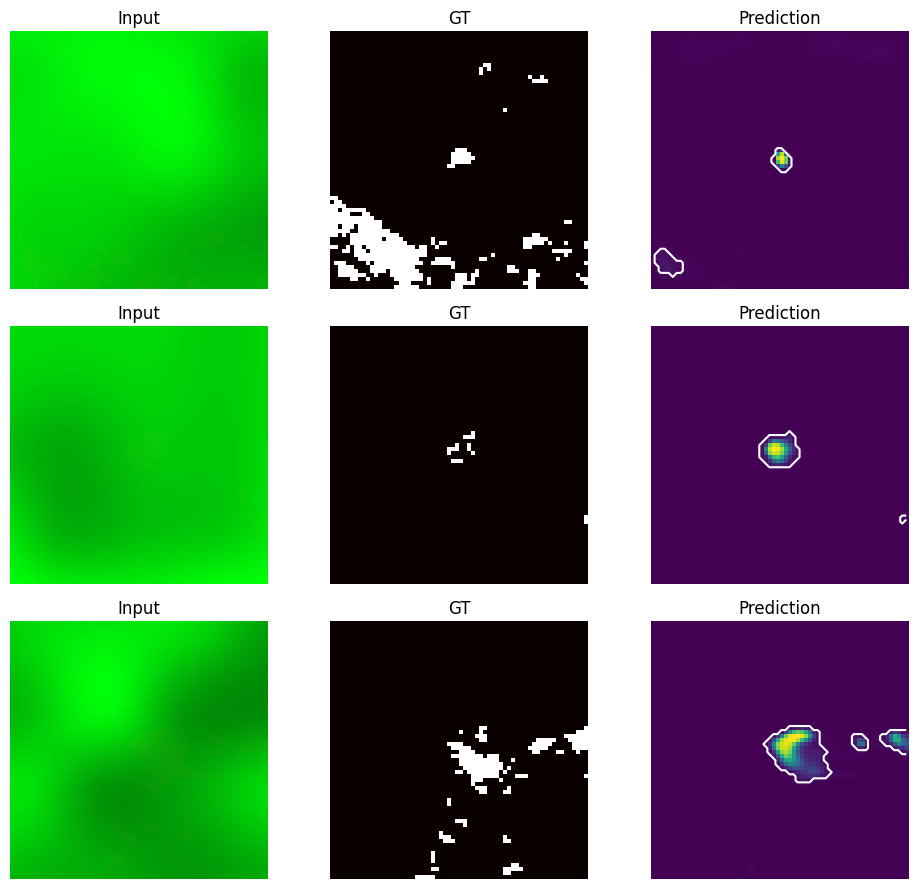

In [ ]:
# =============================================================
# 7) Test-set evaluation + qualitative checks
# =============================================================
#@torch.no_grad()

test_metrics, confusion = run_test(test_loader)
print("TEST metrics:", test_metrics)
print("Confusion counts:", confusion)

visualize_predictions(test_loader, n=3)

## Minus Fuel Ablation

In [ ]:
minus_fuel_channels = ['prev_fire',
 'u',
 'v',
 'temp',
 'rh',
 'ndvi',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

In [ ]:
# =============================================================
## 1) Data pipeline hookup + loaders + channel stats
## =============================================================
from torch.utils.data import DataLoader, WeightedRandomSampler
NPZ_ROOT = mndws_dp.NPZ_ROOT
paths = mndws_dp.WildfirePaths(NPZ_ROOT)
CHANNELS =minus_fuel_channels  # tweak here for ablations
print(f"Using {len(CHANNELS)} channels: {CHANNELS}")

train_ds = mndws_dp.WildfireDataset(paths, split="train", max_samples=None, channels=CHANNELS)
val_ds   = mndws_dp.WildfireDataset(paths, split="eval",  max_samples=None, channels=CHANNELS)
test_ds  = mndws_dp.WildfireDataset(paths, split="test",  max_samples=None, channels=CHANNELS)

BATCH_SIZE = 8
MAX_PARALLEL_WORKERS = min(8, max(2, (os.cpu_count() or 4) // 2))
# Training benefits from multiple workers, but evaluation/test often run on memory-constrained nodes.
TRAIN_WORKERS = MAX_PARALLEL_WORKERS
EVAL_WORKERS = 0 if os.environ.get("MNDWS_EVAL_ALLOW_WORKERS", "0") == "0" else min(4, MAX_PARALLEL_WORKERS)
PIN_MEMORY = device.type == "cuda"

def make_balanced_loader(ds, *, batch_size, shuffle, upweight_positive, num_workers, pin_memory):
    sampler = None
    if upweight_positive:
        weights = []
        for f in ds.files:
            try:
                with np.load(f, mmap_mode="r") as z:
                    weights.append(5.0 if float(z["next_fire"].sum()) > 0 else 1.0)
            except Exception:
                weights.append(1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    loader_kwargs = dict(batch_size=batch_size, pin_memory=pin_memory)
    if num_workers > 0:
        loader_kwargs["num_workers"] = num_workers
        loader_kwargs["persistent_workers"] = True
        loader_kwargs["prefetch_factor"] = 2
    else:
        loader_kwargs["num_workers"] = 0
    if sampler is not None:
        return DataLoader(ds, sampler=sampler, shuffle=False, **loader_kwargs)
    return DataLoader(ds, shuffle=shuffle, **loader_kwargs)

train_loader = make_balanced_loader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, upweight_positive=True,
    num_workers=TRAIN_WORKERS, pin_memory=PIN_MEMORY
)
val_loader   = make_balanced_loader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
test_loader  = make_balanced_loader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
print(f"DataLoader workers -> train: {TRAIN_WORKERS}, val: {EVAL_WORKERS}, test: {EVAL_WORKERS}; pin_memory={PIN_MEMORY}")

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=4000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print("Channel stats computed ->", meanC.shape, stdC.shape)


# =============================================================
# 3) Model definition – ResNet-18 encoder + lightweight decoder
# =============================================================
model = ResNet18UNet(in_ch=len(CHANNELS), base_ch=96, pretrained=True).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M")

# =============================================================
## 4) Losses, metrics, and normalization helpers
## =============================================================
criterion = FocalDiceLoss(alpha=0.3, gamma=2.0, dice_weight=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

if device.type == "cuda":
    scaler = torch.amp.GradScaler("cuda", enabled=True)
else:
    scaler = _NoOpGradScaler()

# =============================================================
# 6) Training driver (configurable epochs, patience, logging)
# =============================================================
MAX_EPOCHS = 50
PATIENCE = 6
history = {"train_loss": [], "val_AP": [], "val_F1": [], "val_thr": [], "lr": [], "epoch_time": []}
best_ap = -1
best_state = None
best_epoch = -1
tiles_seen = []
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)
for epoch in range(MAX_EPOCHS):
    torch.cuda.empty_cache() if device.type == "cuda" else None
    torch.mps.empty_cache() if hasattr(torch, "mps") and device.type == "mps" else None
    start = time.perf_counter()
    tr_loss, tiles = train_one_epoch(epoch)
    metrics = evaluate(val_loader)
    scheduler.step()
    duration = time.perf_counter() - start
    throughput = tiles / duration if duration > 0 else float('nan')
    history["train_loss"].append(tr_loss)
    history["val_AP"].append(metrics["AP"])
    history["val_F1"].append(metrics["best_F1"])
    history["val_thr"].append(metrics["best_thr"])
    history["lr"].append(optimizer.param_groups[0]["lr"])
    history["epoch_time"].append({"sec": duration, "throughput_tiles_per_s": throughput})
    tiles_seen.append(tiles)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f} | val AP {metrics['AP']:.4f} | val F1* {metrics['best_F1']:.4f} | thr {metrics['best_thr']:.3f} | {duration:.1f}s")
    if metrics["AP"] > best_ap:
        best_ap = metrics["AP"]
        best_state = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "metrics": metrics}
        best_epoch = epoch
        save_checkpoint(best_state, "best.pt")
    if epoch - best_epoch >= PATIENCE:
        print(f"Early stopping at epoch {epoch} (best @ {best_epoch})")
        break

if best_state is not None:
    model.load_state_dict(best_state["model"])
training_summary = {
    "best_epoch": best_epoch,
    "best_AP": best_ap,
    "history": history,
    "tiles_total": int(np.sum(tiles_seen))
}
if device.type == "cuda":
    training_summary["peak_gpu_gb"] = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
json.dump(training_summary, open(ART_ROOT / "training_summary.json", "w"), indent=2)
training_summary



Using 18 channels: ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']
DataLoader workers -> train: 4, val: 0, test: 0; pin_memory=True
Channel stats computed -> torch.Size([18]) torch.Size([18])
Model parameters: 19.41 M


train[00]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 00 | train 0.3507 | val AP 0.2728 | val F1* 0.3675 | thr 0.237 | 70.0s


train[01]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 01 | train 0.3422 | val AP 0.2322 | val F1* 0.3327 | thr 0.457 | 69.0s


train[02]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 02 | train 0.3343 | val AP 0.2773 | val F1* 0.3540 | thr 0.531 | 69.2s


train[03]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 03 | train 0.3311 | val AP 0.2431 | val F1* 0.3262 | thr 0.553 | 69.7s


train[04]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 04 | train 0.3235 | val AP 0.3057 | val F1* 0.3744 | thr 0.261 | 69.9s


train[05]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 05 | train 0.3136 | val AP 0.2987 | val F1* 0.3706 | thr 0.217 | 69.6s


train[06]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 06 | train 0.3057 | val AP 0.2486 | val F1* 0.3269 | thr 0.141 | 69.5s


train[07]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 07 | train 0.2999 | val AP 0.2028 | val F1* 0.2717 | thr 0.370 | 69.6s


train[08]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 08 | train 0.2943 | val AP 0.3117 | val F1* 0.3845 | thr 0.050 | 69.6s


train[09]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 09 | train 0.2869 | val AP 0.2496 | val F1* 0.3220 | thr 0.153 | 69.9s


train[10]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 10 | train 0.2837 | val AP 0.1876 | val F1* 0.2670 | thr 0.120 | 70.2s


train[11]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 11 | train 0.2756 | val AP 0.2483 | val F1* 0.3093 | thr 0.054 | 69.2s


train[12]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 12 | train 0.2722 | val AP 0.3836 | val F1* 0.4492 | thr 0.055 | 69.3s


train[13]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 13 | train 0.2691 | val AP 0.3278 | val F1* 0.3898 | thr 0.126 | 69.6s


train[14]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 14 | train 0.2644 | val AP 0.3975 | val F1* 0.4476 | thr 0.060 | 71.1s


train[15]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 15 | train 0.2605 | val AP 0.3541 | val F1* 0.4014 | thr 0.019 | 71.4s


train[16]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 16 | train 0.2565 | val AP 0.3894 | val F1* 0.4472 | thr 0.044 | 71.0s


train[17]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 17 | train 0.2540 | val AP 0.3837 | val F1* 0.4372 | thr 0.028 | 70.4s


train[18]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 18 | train 0.2502 | val AP 0.2670 | val F1* 0.3331 | thr 0.041 | 70.3s


train[19]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 19 | train 0.2494 | val AP 0.3877 | val F1* 0.4341 | thr 0.032 | 69.8s


train[20]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 20 | train 0.2471 | val AP 0.4148 | val F1* 0.4586 | thr 0.030 | 72.4s


train[21]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 21 | train 0.2430 | val AP 0.3882 | val F1* 0.4282 | thr 0.020 | 72.0s


train[22]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 22 | train 0.2401 | val AP 0.3510 | val F1* 0.4034 | thr 0.018 | 71.0s


train[23]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 23 | train 0.2397 | val AP 0.4610 | val F1* 0.4904 | thr 0.039 | 70.6s


train[24]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 24 | train 0.2370 | val AP 0.3517 | val F1* 0.3957 | thr 0.023 | 71.2s


train[25]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 25 | train 0.2332 | val AP 0.2914 | val F1* 0.3364 | thr 0.022 | 71.4s


train[26]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 26 | train 0.2339 | val AP 0.3131 | val F1* 0.3598 | thr 0.017 | 71.6s


train[27]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 27 | train 0.2289 | val AP 0.4354 | val F1* 0.4693 | thr 0.022 | 70.3s


train[28]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 28 | train 0.2296 | val AP 0.2953 | val F1* 0.3426 | thr 0.014 | 71.3s


train[29]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 29 | train 0.2274 | val AP 0.2971 | val F1* 0.3440 | thr 0.020 | 71.3s
Early stopping at epoch 29 (best @ 23)


{'best_epoch': 23,
 'best_AP': 0.460983481264717,
 'history': {'train_loss': [0.35065238262490156,
   0.3421899634728451,
   0.33426603190325554,
   0.3310770514066955,
   0.3234920181829595,
   0.3136152058687313,
   0.30566096986099156,
   0.29986383625734525,
   0.29426902328417204,
   0.28687519922793214,
   0.2837409179545452,
   0.27558848693026544,
   0.27217798217953165,
   0.26911745879919846,
   0.2644086812811863,
   0.26051921755363483,
   0.256490982480182,
   0.25397217774370845,
   0.2502074109569336,
   0.2493870075010589,
   0.24714013512260607,
   0.2430133324766647,
   0.24012675514574958,
   0.23970213346077407,
   0.23702449239303336,
   0.2331933165525021,
   0.23390181695554255,
   0.2289003106961879,
   0.2295840254403977,
   0.22739963010249997],
  'val_AP': [0.272789489732421,
   0.2322156425934997,
   0.2773394583502606,
   0.24314669761949817,
   0.30573723418804266,
   0.2987098104731949,
   0.24859565820457136,
   0.20284897341370234,
   0.3117244619387739

In [ ]:
# =============================================================
# 7) Test-set evaluation + qualitative checks
# =============================================================
#@torch.no_grad()

test_metrics, confusion = run_test(test_loader)
print("TEST metrics:", test_metrics)
print("Confusion counts:", confusion)

visualize_predictions(test_loader, n=3)

## Minus Vegetitation and Drought Ablation

In [ ]:
minus_vegd_channels = ['prev_fire',
 'u',
 'v',
 'temp',
 'rh',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pr',
 'bi',
 'chili',
 'fuel1',
 'fuel2',
 'fuel3',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

In [ ]:
# =============================================================
## 1) Data pipeline hookup + loaders + channel stats
## =============================================================
from torch.utils.data import DataLoader, WeightedRandomSampler
NPZ_ROOT = mndws_dp.NPZ_ROOT
paths = mndws_dp.WildfirePaths(NPZ_ROOT)
CHANNELS =minus_vegd_channels  # tweak here for ablations
print(f"Using {len(CHANNELS)} channels: {CHANNELS}")

train_ds = mndws_dp.WildfireDataset(paths, split="train", max_samples=None, channels=CHANNELS)
val_ds   = mndws_dp.WildfireDataset(paths, split="eval",  max_samples=None, channels=CHANNELS)
test_ds  = mndws_dp.WildfireDataset(paths, split="test",  max_samples=None, channels=CHANNELS)

BATCH_SIZE = 8
MAX_PARALLEL_WORKERS = min(8, max(2, (os.cpu_count() or 4) // 2))
# Training benefits from multiple workers, but evaluation/test often run on memory-constrained nodes.
TRAIN_WORKERS = MAX_PARALLEL_WORKERS
EVAL_WORKERS = 0 if os.environ.get("MNDWS_EVAL_ALLOW_WORKERS", "0") == "0" else min(4, MAX_PARALLEL_WORKERS)
PIN_MEMORY = device.type == "cuda"

def make_balanced_loader(ds, *, batch_size, shuffle, upweight_positive, num_workers, pin_memory):
    sampler = None
    if upweight_positive:
        weights = []
        for f in ds.files:
            try:
                with np.load(f, mmap_mode="r") as z:
                    weights.append(5.0 if float(z["next_fire"].sum()) > 0 else 1.0)
            except Exception:
                weights.append(1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    loader_kwargs = dict(batch_size=batch_size, pin_memory=pin_memory)
    if num_workers > 0:
        loader_kwargs["num_workers"] = num_workers
        loader_kwargs["persistent_workers"] = True
        loader_kwargs["prefetch_factor"] = 2
    else:
        loader_kwargs["num_workers"] = 0
    if sampler is not None:
        return DataLoader(ds, sampler=sampler, shuffle=False, **loader_kwargs)
    return DataLoader(ds, shuffle=shuffle, **loader_kwargs)

train_loader = make_balanced_loader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, upweight_positive=True,
    num_workers=TRAIN_WORKERS, pin_memory=PIN_MEMORY
)
val_loader   = make_balanced_loader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
test_loader  = make_balanced_loader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
print(f"DataLoader workers -> train: {TRAIN_WORKERS}, val: {EVAL_WORKERS}, test: {EVAL_WORKERS}; pin_memory={PIN_MEMORY}")

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=4000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print("Channel stats computed ->", meanC.shape, stdC.shape)


# =============================================================
# 3) Model definition – ResNet-18 encoder + lightweight decoder
# =============================================================
model = ResNet18UNet(in_ch=len(CHANNELS), base_ch=96, pretrained=True).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M")

# =============================================================
## 4) Losses, metrics, and normalization helpers
## =============================================================
criterion = FocalDiceLoss(alpha=0.3, gamma=2.0, dice_weight=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

if device.type == "cuda":
    scaler = torch.amp.GradScaler("cuda", enabled=True)
else:
    scaler = _NoOpGradScaler()

# =============================================================
# 6) Training driver (configurable epochs, patience, logging)
# =============================================================
MAX_EPOCHS = 50
PATIENCE = 6
history = {"train_loss": [], "val_AP": [], "val_F1": [], "val_thr": [], "lr": [], "epoch_time": []}
best_ap = -1
best_state = None
best_epoch = -1
tiles_seen = []
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)
for epoch in range(MAX_EPOCHS):
    torch.cuda.empty_cache() if device.type == "cuda" else None
    torch.mps.empty_cache() if hasattr(torch, "mps") and device.type == "mps" else None
    start = time.perf_counter()
    tr_loss, tiles = train_one_epoch(epoch)
    metrics = evaluate(val_loader)
    scheduler.step()
    duration = time.perf_counter() - start
    throughput = tiles / duration if duration > 0 else float('nan')
    history["train_loss"].append(tr_loss)
    history["val_AP"].append(metrics["AP"])
    history["val_F1"].append(metrics["best_F1"])
    history["val_thr"].append(metrics["best_thr"])
    history["lr"].append(optimizer.param_groups[0]["lr"])
    history["epoch_time"].append({"sec": duration, "throughput_tiles_per_s": throughput})
    tiles_seen.append(tiles)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f} | val AP {metrics['AP']:.4f} | val F1* {metrics['best_F1']:.4f} | thr {metrics['best_thr']:.3f} | {duration:.1f}s")
    if metrics["AP"] > best_ap:
        best_ap = metrics["AP"]
        best_state = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "metrics": metrics}
        best_epoch = epoch
        save_checkpoint(best_state, "best.pt")
    if epoch - best_epoch >= PATIENCE:
        print(f"Early stopping at epoch {epoch} (best @ {best_epoch})")
        break

if best_state is not None:
    model.load_state_dict(best_state["model"])
training_summary = {
    "best_epoch": best_epoch,
    "best_AP": best_ap,
    "history": history,
    "tiles_total": int(np.sum(tiles_seen))
}
if device.type == "cuda":
    training_summary["peak_gpu_gb"] = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
json.dump(training_summary, open(ART_ROOT / "training_summary.json", "w"), indent=2)
training_summary



Using 19 channels: ['prev_fire', 'u', 'v', 'temp', 'rh', 'slope', 'aspect', 'barrier', 'erc', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
DataLoader workers -> train: 4, val: 0, test: 0; pin_memory=True
Channel stats computed -> torch.Size([19]) torch.Size([19])
Model parameters: 19.41 M


train[00]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 00 | train 0.3528 | val AP 0.2468 | val F1* 0.3544 | thr 0.295 | 73.8s


train[01]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 01 | train 0.3407 | val AP 0.2750 | val F1* 0.3721 | thr 0.292 | 72.2s


train[02]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 02 | train 0.3369 | val AP 0.2456 | val F1* 0.3239 | thr 0.107 | 72.2s


train[03]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 03 | train 0.3299 | val AP 0.3023 | val F1* 0.3738 | thr 0.387 | 70.8s


train[04]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 04 | train 0.3231 | val AP 0.3138 | val F1* 0.3893 | thr 0.337 | 71.0s


train[05]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 05 | train 0.3145 | val AP 0.2627 | val F1* 0.3152 | thr 0.566 | 72.1s


train[06]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 06 | train 0.3064 | val AP 0.3262 | val F1* 0.3893 | thr 0.216 | 72.4s


train[07]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 07 | train 0.2988 | val AP 0.3593 | val F1* 0.4216 | thr 0.102 | 72.3s


train[08]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 08 | train 0.2942 | val AP 0.3571 | val F1* 0.4283 | thr 0.508 | 71.4s


train[09]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 09 | train 0.2900 | val AP 0.3775 | val F1* 0.4395 | thr 0.131 | 72.3s


train[10]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 10 | train 0.2820 | val AP 0.3256 | val F1* 0.3824 | thr 0.145 | 71.9s


train[11]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 11 | train 0.2797 | val AP 0.3630 | val F1* 0.4223 | thr 0.111 | 71.6s


train[12]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 12 | train 0.2734 | val AP 0.3204 | val F1* 0.3859 | thr 0.071 | 72.1s


train[13]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 13 | train 0.2716 | val AP 0.3218 | val F1* 0.3795 | thr 0.122 | 72.2s


train[14]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 14 | train 0.2674 | val AP 0.4320 | val F1* 0.4723 | thr 0.143 | 71.9s


train[15]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 15 | train 0.2637 | val AP 0.3202 | val F1* 0.3866 | thr 0.076 | 72.1s


train[16]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 16 | train 0.2599 | val AP 0.4687 | val F1* 0.5047 | thr 0.114 | 72.5s


train[17]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 17 | train 0.2565 | val AP 0.3714 | val F1* 0.4166 | thr 0.076 | 72.1s


train[18]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 18 | train 0.2536 | val AP 0.2966 | val F1* 0.3565 | thr 0.047 | 71.4s


train[19]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 19 | train 0.2512 | val AP 0.4084 | val F1* 0.4576 | thr 0.065 | 71.9s


train[20]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 20 | train 0.2492 | val AP 0.4216 | val F1* 0.4582 | thr 0.044 | 72.8s


train[21]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 21 | train 0.2422 | val AP 0.4568 | val F1* 0.4917 | thr 0.076 | 72.4s


train[22]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 22 | train 0.2420 | val AP 0.3818 | val F1* 0.4277 | thr 0.037 | 72.1s
Early stopping at epoch 22 (best @ 16)


{'best_epoch': 16,
 'best_AP': 0.46865495246463207,
 'history': {'train_loss': [0.3528242680906504,
   0.3407230141269273,
   0.33685416868459506,
   0.32992107348729427,
   0.32310523901763727,
   0.3145284264212376,
   0.30644004013031434,
   0.29875188540707537,
   0.29422590896410994,
   0.28996736794760986,
   0.2819874812131446,
   0.2796873747285894,
   0.2733709056686447,
   0.27163749023416356,
   0.2673597624858988,
   0.26373463753036913,
   0.25986556862144733,
   0.256545532623972,
   0.2535569270931909,
   0.2512383371879595,
   0.24923505432874116,
   0.2421686151078169,
   0.24195432923882437],
  'val_AP': [0.24677446533184222,
   0.27502627308404815,
   0.24564997996504384,
   0.302266508562726,
   0.3137873129152261,
   0.26265463633277936,
   0.3261864701348685,
   0.3593172335985649,
   0.35709582619977387,
   0.3775179729473186,
   0.3256368778690469,
   0.36299751571238936,
   0.3204181853042403,
   0.32184755131443304,
   0.4319834320416345,
   0.3201564744210791

test:   0%|          | 0/377 [00:00<?, ?it/s]

TEST metrics: {'AP': 0.3760497683060023, 'best_F1': 0.42436096676956, 'best_thr': 0.0341852605342865, 'best_prec': 0.3521010358037788, 'best_rec': 0.5339385015806168}
Confusion counts: {'TP': 199811.0, 'FP': 367671.0, 'FN': 174410.0}


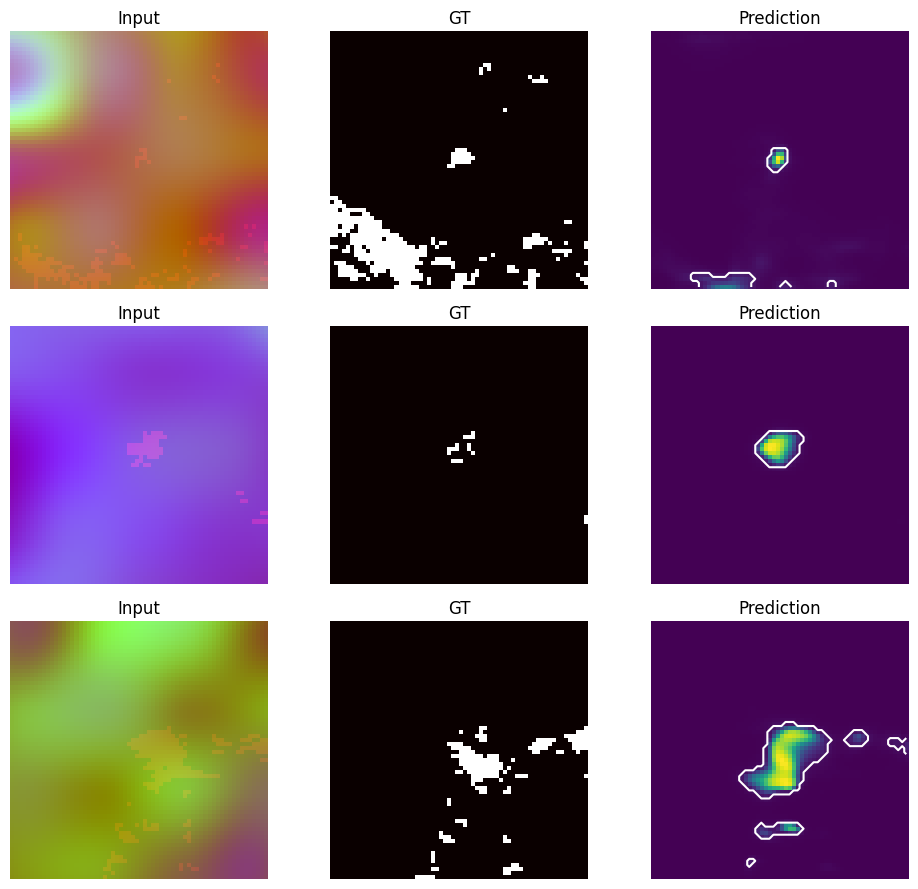

In [ ]:
# =============================================================
# 7) Test-set evaluation + qualitative checks
# =============================================================
#@torch.no_grad()

test_metrics, confusion = run_test(test_loader)
print("TEST metrics:", test_metrics)
print("Confusion counts:", confusion)

visualize_predictions(test_loader, n=3)

## Minus Topography Ablation

In [ ]:
minus_topog_channels = ['prev_fire',
 'u',
 'v',
 'temp',
 'rh',
 'ndvi',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

In [ ]:
# =============================================================
## 1) Data pipeline hookup + loaders + channel stats
## =============================================================
from torch.utils.data import DataLoader, WeightedRandomSampler
NPZ_ROOT = mndws_dp.NPZ_ROOT
paths = mndws_dp.WildfirePaths(NPZ_ROOT)
CHANNELS =minus_topog_channels  # tweak here for ablations
print(f"Using {len(CHANNELS)} channels: {CHANNELS}")

train_ds = mndws_dp.WildfireDataset(paths, split="train", max_samples=None, channels=CHANNELS)
val_ds   = mndws_dp.WildfireDataset(paths, split="eval",  max_samples=None, channels=CHANNELS)
test_ds  = mndws_dp.WildfireDataset(paths, split="test",  max_samples=None, channels=CHANNELS)

BATCH_SIZE = 8
MAX_PARALLEL_WORKERS = min(8, max(2, (os.cpu_count() or 4) // 2))
# Training benefits from multiple workers, but evaluation/test often run on memory-constrained nodes.
TRAIN_WORKERS = MAX_PARALLEL_WORKERS
EVAL_WORKERS = 0 if os.environ.get("MNDWS_EVAL_ALLOW_WORKERS", "0") == "0" else min(4, MAX_PARALLEL_WORKERS)
PIN_MEMORY = device.type == "cuda"

def make_balanced_loader(ds, *, batch_size, shuffle, upweight_positive, num_workers, pin_memory):
    sampler = None
    if upweight_positive:
        weights = []
        for f in ds.files:
            try:
                with np.load(f, mmap_mode="r") as z:
                    weights.append(5.0 if float(z["next_fire"].sum()) > 0 else 1.0)
            except Exception:
                weights.append(1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    loader_kwargs = dict(batch_size=batch_size, pin_memory=pin_memory)
    if num_workers > 0:
        loader_kwargs["num_workers"] = num_workers
        loader_kwargs["persistent_workers"] = True
        loader_kwargs["prefetch_factor"] = 2
    else:
        loader_kwargs["num_workers"] = 0
    if sampler is not None:
        return DataLoader(ds, sampler=sampler, shuffle=False, **loader_kwargs)
    return DataLoader(ds, shuffle=shuffle, **loader_kwargs)

train_loader = make_balanced_loader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, upweight_positive=True,
    num_workers=TRAIN_WORKERS, pin_memory=PIN_MEMORY
)
val_loader   = make_balanced_loader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
test_loader  = make_balanced_loader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
print(f"DataLoader workers -> train: {TRAIN_WORKERS}, val: {EVAL_WORKERS}, test: {EVAL_WORKERS}; pin_memory={PIN_MEMORY}")

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=4000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print("Channel stats computed ->", meanC.shape, stdC.shape)


# =============================================================
# 3) Model definition – ResNet-18 encoder + lightweight decoder
# =============================================================
model = ResNet18UNet(in_ch=len(CHANNELS), base_ch=96, pretrained=True).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M")

# =============================================================
## 4) Losses, metrics, and normalization helpers
## =============================================================
criterion = FocalDiceLoss(alpha=0.3, gamma=2.0, dice_weight=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

if device.type == "cuda":
    scaler = torch.amp.GradScaler("cuda", enabled=True)
else:
    scaler = _NoOpGradScaler()

# =============================================================
# 6) Training driver (configurable epochs, patience, logging)
# =============================================================
MAX_EPOCHS = 50
PATIENCE = 6
history = {"train_loss": [], "val_AP": [], "val_F1": [], "val_thr": [], "lr": [], "epoch_time": []}
best_ap = -1
best_state = None
best_epoch = -1
tiles_seen = []
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)
for epoch in range(MAX_EPOCHS):
    torch.cuda.empty_cache() if device.type == "cuda" else None
    torch.mps.empty_cache() if hasattr(torch, "mps") and device.type == "mps" else None
    start = time.perf_counter()
    tr_loss, tiles = train_one_epoch(epoch)
    metrics = evaluate(val_loader)
    scheduler.step()
    duration = time.perf_counter() - start
    throughput = tiles / duration if duration > 0 else float('nan')
    history["train_loss"].append(tr_loss)
    history["val_AP"].append(metrics["AP"])
    history["val_F1"].append(metrics["best_F1"])
    history["val_thr"].append(metrics["best_thr"])
    history["lr"].append(optimizer.param_groups[0]["lr"])
    history["epoch_time"].append({"sec": duration, "throughput_tiles_per_s": throughput})
    tiles_seen.append(tiles)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f} | val AP {metrics['AP']:.4f} | val F1* {metrics['best_F1']:.4f} | thr {metrics['best_thr']:.3f} | {duration:.1f}s")
    if metrics["AP"] > best_ap:
        best_ap = metrics["AP"]
        best_state = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "metrics": metrics}
        best_epoch = epoch
        save_checkpoint(best_state, "best.pt")
    if epoch - best_epoch >= PATIENCE:
        print(f"Early stopping at epoch {epoch} (best @ {best_epoch})")
        break

if best_state is not None:
    model.load_state_dict(best_state["model"])
training_summary = {
    "best_epoch": best_epoch,
    "best_AP": best_ap,
    "history": history,
    "tiles_total": int(np.sum(tiles_seen))
}
if device.type == "cuda":
    training_summary["peak_gpu_gb"] = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
json.dump(training_summary, open(ART_ROOT / "training_summary.json", "w"), indent=2)
training_summary



Using 16 channels: ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']
DataLoader workers -> train: 4, val: 0, test: 0; pin_memory=True
Channel stats computed -> torch.Size([16]) torch.Size([16])
Model parameters: 19.40 M


train[00]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 00 | train 0.3499 | val AP 0.2814 | val F1* 0.3893 | thr 0.493 | 69.9s


train[01]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 01 | train 0.3415 | val AP 0.2789 | val F1* 0.3756 | thr 0.238 | 70.4s


train[02]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 02 | train 0.3366 | val AP 0.2680 | val F1* 0.3523 | thr 0.092 | 70.1s


train[03]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 03 | train 0.3309 | val AP 0.2960 | val F1* 0.3728 | thr 0.191 | 70.8s


train[04]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 04 | train 0.3238 | val AP 0.3111 | val F1* 0.3843 | thr 0.255 | 70.1s


train[05]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 05 | train 0.3146 | val AP 0.2613 | val F1* 0.3357 | thr 0.225 | 68.3s


train[06]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 06 | train 0.3111 | val AP 0.2958 | val F1* 0.3796 | thr 0.080 | 69.2s


train[07]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 07 | train 0.3027 | val AP 0.2804 | val F1* 0.3518 | thr 0.243 | 69.5s


train[08]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 08 | train 0.2977 | val AP 0.2495 | val F1* 0.3175 | thr 0.125 | 68.8s


train[09]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 09 | train 0.2909 | val AP 0.3208 | val F1* 0.3905 | thr 0.136 | 68.6s


train[10]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 10 | train 0.2885 | val AP 0.3764 | val F1* 0.4406 | thr 0.107 | 69.4s


train[11]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 11 | train 0.2821 | val AP 0.3104 | val F1* 0.3730 | thr 0.065 | 68.4s


train[12]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 12 | train 0.2787 | val AP 0.3065 | val F1* 0.3931 | thr 0.149 | 69.2s


train[13]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 13 | train 0.2759 | val AP 0.3918 | val F1* 0.4541 | thr 0.045 | 68.6s


train[14]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 14 | train 0.2706 | val AP 0.2685 | val F1* 0.3415 | thr 0.126 | 67.9s


train[15]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 15 | train 0.2679 | val AP 0.3715 | val F1* 0.4401 | thr 0.073 | 67.9s


train[16]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 16 | train 0.2644 | val AP 0.4227 | val F1* 0.4675 | thr 0.123 | 69.0s


train[17]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 17 | train 0.2617 | val AP 0.3416 | val F1* 0.3974 | thr 0.076 | 67.9s


train[18]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 18 | train 0.2604 | val AP 0.3141 | val F1* 0.3845 | thr 0.029 | 68.2s


train[19]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 19 | train 0.2558 | val AP 0.4326 | val F1* 0.4807 | thr 0.059 | 68.9s


train[20]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 20 | train 0.2546 | val AP 0.2384 | val F1* 0.2986 | thr 0.034 | 68.3s


train[21]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 21 | train 0.2498 | val AP 0.4560 | val F1* 0.5009 | thr 0.116 | 67.5s


train[22]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 22 | train 0.2489 | val AP 0.3689 | val F1* 0.4155 | thr 0.033 | 69.3s


train[23]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 23 | train 0.2456 | val AP 0.3965 | val F1* 0.4383 | thr 0.027 | 68.3s


train[24]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 24 | train 0.2438 | val AP 0.3984 | val F1* 0.4432 | thr 0.022 | 69.2s


train[25]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 25 | train 0.2407 | val AP 0.4292 | val F1* 0.4715 | thr 0.017 | 67.5s


train[26]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 26 | train 0.2389 | val AP 0.3721 | val F1* 0.4212 | thr 0.015 | 67.5s


train[27]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 27 | train 0.2392 | val AP 0.3551 | val F1* 0.4052 | thr 0.017 | 68.4s
Early stopping at epoch 27 (best @ 21)


{'best_epoch': 21,
 'best_AP': 0.45601349112338285,
 'history': {'train_loss': [0.3499460717183477,
   0.3415229174394781,
   0.33664957062468875,
   0.3309125502113594,
   0.3237856101623782,
   0.31458615483276675,
   0.3110571726351858,
   0.30265014091291637,
   0.29767601117449366,
   0.2909473254302471,
   0.2885142505643312,
   0.28211103083228034,
   0.27866086136759377,
   0.275859629730056,
   0.2706010689648666,
   0.2679198285085088,
   0.26442456182734136,
   0.2617036131310693,
   0.2603945717630636,
   0.2557751563901316,
   0.254625439957301,
   0.24981485258929767,
   0.24887291189958724,
   0.24556866001852404,
   0.24382867161322208,
   0.24068948823054315,
   0.23889547010387055,
   0.23919711723254444],
  'val_AP': [0.28140169639295654,
   0.27886465387997983,
   0.26799030469709456,
   0.29598918326203055,
   0.31109012628528404,
   0.2613182588249657,
   0.2957669191774327,
   0.2803858647416383,
   0.24946222439407234,
   0.3208218958834146,
   0.376372743803427

In [ ]:
# =============================================================
# 7) Test-set evaluation + qualitative checks
# =============================================================
#@torch.no_grad()

test_metrics, confusion = run_test(test_loader)
print("TEST metrics:", test_metrics)
print("Confusion counts:", confusion)

visualize_predictions(test_loader, n=3)

# Ablation 2: Dependence on Previous Burn Mask

In [ ]:
WITHOUTBURN_CHANNELS = [
 'u',
 'v',
 'temp',
 'rh',
 'ndvi',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'fuel1',
 'fuel2',
 'fuel3',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

In [ ]:
# =============================================================
## 1) Data pipeline hookup + loaders + channel stats
## =============================================================
from torch.utils.data import DataLoader, WeightedRandomSampler
NPZ_ROOT = mndws_dp.NPZ_ROOT
paths = mndws_dp.WildfirePaths(NPZ_ROOT)
CHANNELS =WITHOUTBURN_CHANNELS  # tweak here for ablations
print(f"Using {len(CHANNELS)} channels: {CHANNELS}")

train_ds = mndws_dp.WildfireDataset(paths, split="train", max_samples=None, channels=CHANNELS)
val_ds   = mndws_dp.WildfireDataset(paths, split="eval",  max_samples=None, channels=CHANNELS)
test_ds  = mndws_dp.WildfireDataset(paths, split="test",  max_samples=None, channels=CHANNELS)

BATCH_SIZE = 8
MAX_PARALLEL_WORKERS = min(8, max(2, (os.cpu_count() or 4) // 2))
# Training benefits from multiple workers, but evaluation/test often run on memory-constrained nodes.
TRAIN_WORKERS = MAX_PARALLEL_WORKERS
EVAL_WORKERS = 0 if os.environ.get("MNDWS_EVAL_ALLOW_WORKERS", "0") == "0" else min(4, MAX_PARALLEL_WORKERS)
PIN_MEMORY = device.type == "cuda"

def make_balanced_loader(ds, *, batch_size, shuffle, upweight_positive, num_workers, pin_memory):
    sampler = None
    if upweight_positive:
        weights = []
        for f in ds.files:
            try:
                with np.load(f, mmap_mode="r") as z:
                    weights.append(5.0 if float(z["next_fire"].sum()) > 0 else 1.0)
            except Exception:
                weights.append(1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    loader_kwargs = dict(batch_size=batch_size, pin_memory=pin_memory)
    if num_workers > 0:
        loader_kwargs["num_workers"] = num_workers
        loader_kwargs["persistent_workers"] = True
        loader_kwargs["prefetch_factor"] = 2
    else:
        loader_kwargs["num_workers"] = 0
    if sampler is not None:
        return DataLoader(ds, sampler=sampler, shuffle=False, **loader_kwargs)
    return DataLoader(ds, shuffle=shuffle, **loader_kwargs)

train_loader = make_balanced_loader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, upweight_positive=True,
    num_workers=TRAIN_WORKERS, pin_memory=PIN_MEMORY
)
val_loader   = make_balanced_loader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
test_loader  = make_balanced_loader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
print(f"DataLoader workers -> train: {TRAIN_WORKERS}, val: {EVAL_WORKERS}, test: {EVAL_WORKERS}; pin_memory={PIN_MEMORY}")

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=4000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print("Channel stats computed ->", meanC.shape, stdC.shape)


# =============================================================
# 3) Model definition – ResNet-18 encoder + lightweight decoder
# =============================================================
model = ResNet18UNet(in_ch=len(CHANNELS), base_ch=96, pretrained=True).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M")

# =============================================================
## 4) Losses, metrics, and normalization helpers
## =============================================================
criterion = FocalDiceLoss(alpha=0.3, gamma=2.0, dice_weight=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

if device.type == "cuda":
    scaler = torch.amp.GradScaler("cuda", enabled=True)
else:
    scaler = _NoOpGradScaler()

# =============================================================
# 6) Training driver (configurable epochs, patience, logging)
# =============================================================
MAX_EPOCHS = 50
PATIENCE = 6
history = {"train_loss": [], "val_AP": [], "val_F1": [], "val_thr": [], "lr": [], "epoch_time": []}
best_ap = -1
best_state = None
best_epoch = -1
tiles_seen = []
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)
for epoch in range(MAX_EPOCHS):
    torch.cuda.empty_cache() if device.type == "cuda" else None
    torch.mps.empty_cache() if hasattr(torch, "mps") and device.type == "mps" else None
    start = time.perf_counter()
    tr_loss, tiles = train_one_epoch(epoch)
    metrics = evaluate(val_loader)
    scheduler.step()
    duration = time.perf_counter() - start
    throughput = tiles / duration if duration > 0 else float('nan')
    history["train_loss"].append(tr_loss)
    history["val_AP"].append(metrics["AP"])
    history["val_F1"].append(metrics["best_F1"])
    history["val_thr"].append(metrics["best_thr"])
    history["lr"].append(optimizer.param_groups[0]["lr"])
    history["epoch_time"].append({"sec": duration, "throughput_tiles_per_s": throughput})
    tiles_seen.append(tiles)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f} | val AP {metrics['AP']:.4f} | val F1* {metrics['best_F1']:.4f} | thr {metrics['best_thr']:.3f} | {duration:.1f}s")
    if metrics["AP"] > best_ap:
        best_ap = metrics["AP"]
        best_state = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "metrics": metrics}
        best_epoch = epoch
        save_checkpoint(best_state, "best.pt")
    if epoch - best_epoch >= PATIENCE:
        print(f"Early stopping at epoch {epoch} (best @ {best_epoch})")
        break

if best_state is not None:
    model.load_state_dict(best_state["model"])
training_summary = {
    "best_epoch": best_epoch,
    "best_AP": best_ap,
    "history": history,
    "tiles_total": int(np.sum(tiles_seen))
}
if device.type == "cuda":
    training_summary["peak_gpu_gb"] = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
json.dump(training_summary, open(ART_ROOT / "training_summary.json", "w"), indent=2)
training_summary



Using 20 channels: ['u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
DataLoader workers -> train: 4, val: 0, test: 0; pin_memory=True
Channel stats computed -> torch.Size([20]) torch.Size([20])
Model parameters: 19.41 M


train[00]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 00 | train 0.3624 | val AP 0.1391 | val F1* 0.2212 | thr 0.425 | 71.7s


train[01]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 01 | train 0.3563 | val AP 0.1453 | val F1* 0.2276 | thr 0.480 | 71.3s


train[02]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 02 | train 0.3541 | val AP 0.1597 | val F1* 0.2373 | thr 0.384 | 71.5s


train[03]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 03 | train 0.3522 | val AP 0.1670 | val F1* 0.2495 | thr 0.413 | 71.6s


train[04]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 04 | train 0.3484 | val AP 0.1733 | val F1* 0.2574 | thr 0.366 | 71.2s


train[05]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 05 | train 0.3459 | val AP 0.1806 | val F1* 0.2669 | thr 0.486 | 70.9s


train[06]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 06 | train 0.3434 | val AP 0.1840 | val F1* 0.2686 | thr 0.436 | 73.0s


train[07]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 07 | train 0.3417 | val AP 0.1907 | val F1* 0.2817 | thr 0.546 | 71.0s


train[08]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 08 | train 0.3372 | val AP 0.2027 | val F1* 0.2923 | thr 0.485 | 71.4s


train[09]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 09 | train 0.3341 | val AP 0.2113 | val F1* 0.2962 | thr 0.397 | 71.6s


train[10]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 10 | train 0.3327 | val AP 0.2088 | val F1* 0.2963 | thr 0.484 | 71.3s


train[11]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 11 | train 0.3303 | val AP 0.2193 | val F1* 0.3017 | thr 0.628 | 71.6s


train[12]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 12 | train 0.3272 | val AP 0.2209 | val F1* 0.3034 | thr 0.466 | 71.1s


train[13]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 13 | train 0.3247 | val AP 0.2371 | val F1* 0.3186 | thr 0.543 | 72.0s


train[14]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 14 | train 0.3221 | val AP 0.2431 | val F1* 0.3207 | thr 0.403 | 70.2s


train[15]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 15 | train 0.3196 | val AP 0.2488 | val F1* 0.3225 | thr 0.613 | 71.1s


train[16]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 16 | train 0.3184 | val AP 0.2507 | val F1* 0.3307 | thr 0.492 | 72.4s


train[17]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 17 | train 0.3156 | val AP 0.2587 | val F1* 0.3354 | thr 0.479 | 71.6s


train[18]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 18 | train 0.3133 | val AP 0.2568 | val F1* 0.3373 | thr 0.422 | 71.1s


train[19]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 19 | train 0.3103 | val AP 0.2691 | val F1* 0.3446 | thr 0.283 | 70.3s


train[20]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 20 | train 0.3082 | val AP 0.2644 | val F1* 0.3429 | thr 0.615 | 70.3s


train[21]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 21 | train 0.3064 | val AP 0.2721 | val F1* 0.3493 | thr 0.460 | 70.5s


train[22]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 22 | train 0.3032 | val AP 0.2809 | val F1* 0.3568 | thr 0.507 | 72.4s


train[23]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 23 | train 0.3010 | val AP 0.2841 | val F1* 0.3567 | thr 0.407 | 70.4s


train[24]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 24 | train 0.2995 | val AP 0.2897 | val F1* 0.3605 | thr 0.329 | 71.6s


train[25]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 25 | train 0.3003 | val AP 0.2964 | val F1* 0.3648 | thr 0.524 | 70.0s


train[26]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 26 | train 0.2957 | val AP 0.2939 | val F1* 0.3651 | thr 0.570 | 71.9s


train[27]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 27 | train 0.2946 | val AP 0.2994 | val F1* 0.3697 | thr 0.543 | 71.3s


train[28]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 28 | train 0.2930 | val AP 0.3030 | val F1* 0.3708 | thr 0.547 | 69.9s


train[29]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 29 | train 0.2909 | val AP 0.3043 | val F1* 0.3730 | thr 0.465 | 72.6s


train[30]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 30 | train 0.2877 | val AP 0.3108 | val F1* 0.3743 | thr 0.610 | 77.2s


train[31]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 31 | train 0.2876 | val AP 0.3122 | val F1* 0.3773 | thr 0.518 | 77.3s


train[32]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 32 | train 0.2877 | val AP 0.3133 | val F1* 0.3772 | thr 0.351 | 76.3s


train[33]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 33 | train 0.2860 | val AP 0.3181 | val F1* 0.3811 | thr 0.334 | 76.3s


train[34]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 34 | train 0.2842 | val AP 0.3181 | val F1* 0.3813 | thr 0.415 | 78.4s


train[35]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 35 | train 0.2824 | val AP 0.3192 | val F1* 0.3839 | thr 0.300 | 77.6s


train[36]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 36 | train 0.2835 | val AP 0.3199 | val F1* 0.3841 | thr 0.447 | 79.0s


train[37]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 37 | train 0.2840 | val AP 0.3192 | val F1* 0.3839 | thr 0.368 | 79.5s


train[38]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 38 | train 0.2827 | val AP 0.3192 | val F1* 0.3835 | thr 0.408 | 82.3s


train[39]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 39 | train 0.2818 | val AP 0.3197 | val F1* 0.3844 | thr 0.502 | 82.4s


train[40]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 40 | train 0.2831 | val AP 0.3199 | val F1* 0.3833 | thr 0.398 | 82.1s


train[41]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 41 | train 0.2836 | val AP 0.3205 | val F1* 0.3842 | thr 0.424 | 81.1s


train[42]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 42 | train 0.2825 | val AP 0.3212 | val F1* 0.3846 | thr 0.415 | 80.4s


train[43]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 43 | train 0.2827 | val AP 0.3225 | val F1* 0.3846 | thr 0.434 | 79.3s


train[44]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 44 | train 0.2816 | val AP 0.3220 | val F1* 0.3848 | thr 0.506 | 77.9s


train[45]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 45 | train 0.2827 | val AP 0.3224 | val F1* 0.3843 | thr 0.356 | 75.4s


train[46]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 46 | train 0.2825 | val AP 0.3232 | val F1* 0.3849 | thr 0.341 | 76.7s


train[47]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 47 | train 0.2802 | val AP 0.3239 | val F1* 0.3867 | thr 0.239 | 74.9s


train[48]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 48 | train 0.2805 | val AP 0.3213 | val F1* 0.3840 | thr 0.440 | 74.7s


train[49]:   0%|          | 0/1759 [00:00<?, ?it/s]

eval:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 49 | train 0.2806 | val AP 0.3218 | val F1* 0.3843 | thr 0.322 | 73.7s


{'best_epoch': 47,
 'best_AP': 0.3239216390415455,
 'history': {'train_loss': [0.36237793672891283,
   0.35631501635683743,
   0.35414971552700264,
   0.3522218390240325,
   0.3483797159806241,
   0.3459429898727611,
   0.3434301923882087,
   0.3417050672431369,
   0.3372042445363207,
   0.3341464042460261,
   0.33266121033852314,
   0.33034331567115305,
   0.3272016041739005,
   0.3247161918807396,
   0.3220602793914476,
   0.31962708903517895,
   0.31835646574947224,
   0.3156086901428348,
   0.31327296504586716,
   0.31034030326053863,
   0.3082384973798305,
   0.30644101591493816,
   0.30319596325524356,
   0.30096439659731034,
   0.2994831786567749,
   0.3003084776650917,
   0.2956727647591613,
   0.2945675637198145,
   0.29299204475063706,
   0.2909348541325368,
   0.287706037274879,
   0.2875957768061,
   0.28768542252222606,
   0.2859880695412822,
   0.28418552971245414,
   0.28240747398243093,
   0.2835393186876759,
   0.28399754465981736,
   0.28274467413807675,
   0.28178851

test:   0%|          | 0/377 [00:00<?, ?it/s]

TEST metrics: {'AP': 0.31995994196725486, 'best_F1': 0.38208100421502167, 'best_thr': 0.267141729593277, 'best_prec': 0.34569100344598586, 'best_rec': 0.42703375812688227}
Confusion counts: {'TP': 159805.0, 'FP': 302472.0, 'FN': 214416.0}


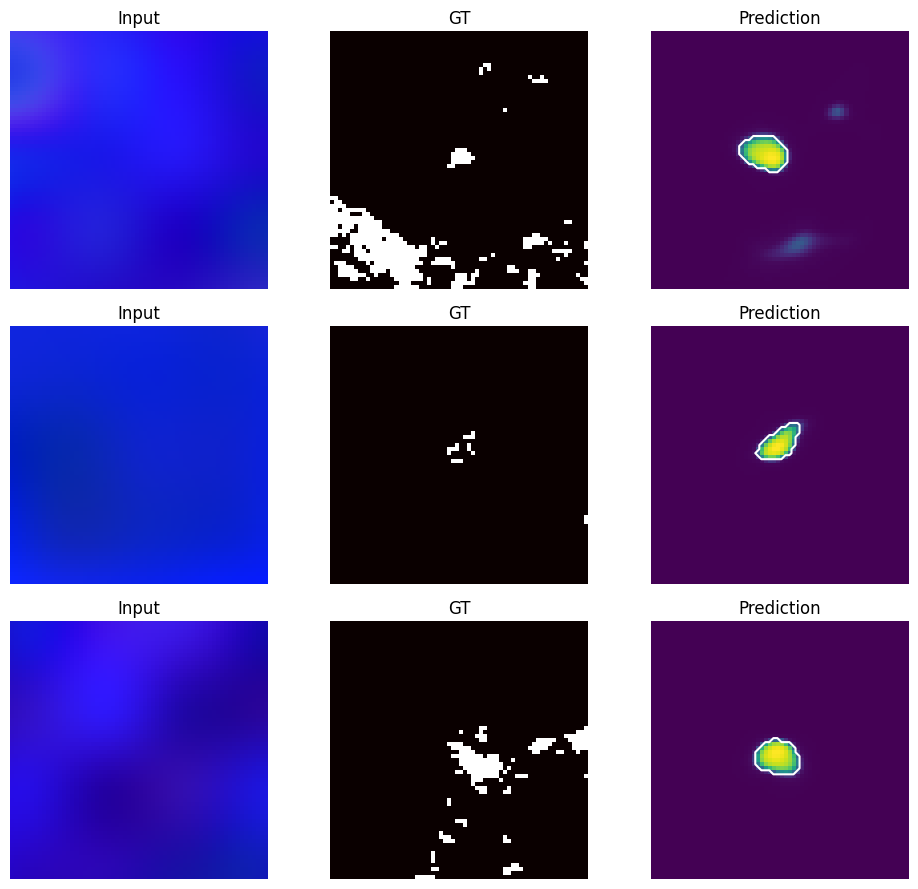

In [ ]:
# =============================================================
# 7) Test-set evaluation + qualitative checks
# =============================================================
#@torch.no_grad()

test_metrics, confusion = run_test(test_loader)
print("TEST metrics:", test_metrics)
print("Confusion counts:", confusion)

visualize_predictions(test_loader, n=3)